In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm

from datetime import datetime

df = pd.read_csv("data/tovar_moving.csv",  index_col=['date'], parse_dates=['date'], dayfirst=True) # считываем датасет
df.head() 

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


Датасет состоит из двух столбцов:

* date — дата заказа;
* quantity (qty) — количество книг, заказанных в этот день.

* Отложите в test последнее значение временного ряда.
* Проанализируйте временной ряд на наличие тренда и сезонности.
* Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (=0.7). Сравните результат с фактическим значением, которое вы отложили вначале.
* Проверьте ряд на стационарность, определите порядок интегрирования.
* Определите порядок модели AR по графику частичной автокорреляции.
* Постройте модель AR и предскажите последнее значение ряда.
* Обратите внимание: модель строится на исходном временном ряду.

Сравните полученные результаты.

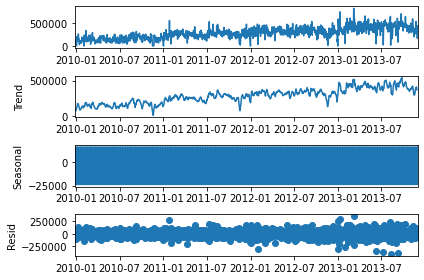

In [2]:
decomposition = seasonal_decompose(df, model='additive') 
decomposition.plot()
pyplot.show() # любуемся результатом

In [3]:
test_df = df.iloc[-1]
train_df = df.iloc[:-1]

In [4]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2013-12-02    225015.522647
Freq: D, dtype: float64

In [5]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  -2.2553026410337975
p-value:  0.18678903123416546
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
есть единичные корни, ряд не стационарен


In [6]:
otg1diff = df.diff(periods=1).dropna()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


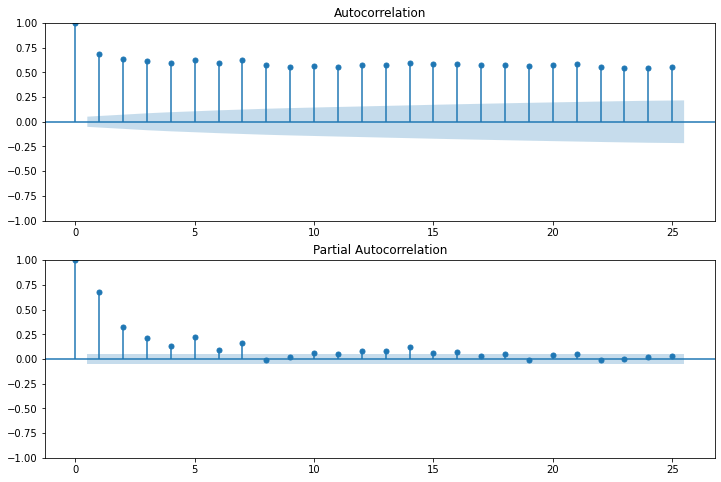

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df, lags=25, ax=ax2)

In [8]:
p = 6

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Mon, 27 Feb 2023   AIC                          36458.111
Time:                        20:40:14   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    318174.284553
Freq: D, dtype: float64

In [10]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_df, ar_pred), mean_squared_error(test_df, exp_pred)

(11166511445.472914, 39533558724.37031)

In [11]:
mean_squared_error(test_df, ar_pred) - mean_squared_error(test_df, exp_pred)

-28367047278.897392